In [26]:
import json
import os
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import betaln
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO
from numpyro.infer.util import init_to_value
from numpyro.infer.autoguide import AutoNormal # computes MAP to make family
from numpyro.optim import Adam, Adagrad
import matplotlib.pyplot as plt
from tqdm import tqdm
from bakeoff.posteriors import beta_posterior
from bakeoff.NumPyro.numpyro_svi import run_svi

from scipy.stats import beta, norm
from scipy.special import expit, logit

This script demonstrates why initialization sensitivity is something we are concerned about. We examine a bimodal beta and demonstrate that choice of intial values factors into which mode the VI algorithm finds.

In [ ]:
# pdf functions
def beta_mixture_pdf(x, alpha_vec, beta_vec, mix_probs):
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    comps = dist.Beta(alpha_vec, beta_vec)           # vectorized over K components
    log_pdf = comps.log_prob(x[:, None])             # [n_x, K]
    pdf = jnp.exp(log_pdf)                           # [n_x, K]
    return (pdf * mix_probs).sum(axis=1)             # [n_x]

def sigmoidnormal_pdf(x, mu, sigma):
    # y ~ Normal(mu, sigma), x = sigmoid(y)
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    y = jnp.log(x) - jnp.log1p(-x)                   # logit(x)
    norm = dist.Normal(mu, sigma)
    return jnp.exp(norm.log_prob(y)) / (x * (1 - x))

def normal_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def beta_mixture_logit_pdf(x, alpha_vec, beta_vec, mix_probs):
    # X = logit(Theta), Theta ~ mixture on (0,1)
    theta = jax.nn.sigmoid(x)
    p_theta = beta_mixture_pdf(theta, alpha_vec, beta_vec, mix_probs)
    jac = theta * (1.0 - theta)                      # d/dx sigmoid(x)
    return p_theta * jac

In [9]:
# ---- Target distribution: *bimodal* Beta mixture on (0,1)
alpha_vec = jnp.array([20.0,  2.0])   
beta_vec  = jnp.array([ 2.0, 20.0])
mix_probs = jnp.array([0.5, 0.5])
n_samples = 0
y_data = jnp.array([])

# Initializations in unconstrained reals
init_mus = [0.05, 0.08, 0.20, 0.80, 0.92, 0.95]

def model(y=None):
    components = dist.Beta(alpha_vec, beta_vec)         # vectorized over 2 comps
    mix = dist.MixtureSameFamily(
        mixing_distribution = dist.Categorical(probs=mix_probs),
        component_distribution = components
    )
    theta = numpyro.sample("theta", mix)
    if y is not None: numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)

optimizer = Adam(step_size=1e-2)
elbo = TraceMeanField_ELBO(num_particles=100)

posteriors = []   # will store (mu_uncon, sigma_uncon) for plotting

# Fit one AutoNormal guide per init, using init_to_value for theta
for i, mu0 in enumerate(init_mus):
    print(f"\nInit {i}: theta_init={mu0}")

    temp_guide = AutoNormal(model,
                            init_loc_fn=init_to_value(values={"theta": jnp.array(mu0)}))
    temp_svi = SVI(model, temp_guide, optimizer, elbo)

    svi_result = temp_svi.run(
        jax.random.PRNGKey(10 + i),
        50_000,
        y=y_data,
    )

    mu_uncon   = float(np.asarray(svi_result.params["theta_auto_loc"]))
    sigma_uncon = float(np.asarray(svi_result.params["theta_auto_scale"]))
    posteriors.append((mu_uncon, sigma_uncon))


Init 0: theta_init=0.05


100%|██████████| 50000/50000 [00:08<00:00, 5764.68it/s, init loss: 2.5607, avg. loss [47501-50000]: 0.7207]



Init 1: theta_init=0.08


100%|██████████| 50000/50000 [00:08<00:00, 5618.13it/s, init loss: 2.2500, avg. loss [47501-50000]: 0.7215]



Init 2: theta_init=0.2


100%|██████████| 50000/50000 [00:09<00:00, 5172.91it/s, init loss: 3.3239, avg. loss [47501-50000]: 0.7205]



Init 3: theta_init=0.8


100%|██████████| 50000/50000 [00:08<00:00, 5621.56it/s, init loss: 3.2677, avg. loss [47501-50000]: 0.7217]



Init 4: theta_init=0.92


100%|██████████| 50000/50000 [00:09<00:00, 5314.35it/s, init loss: 2.2080, avg. loss [47501-50000]: 0.7221]



Init 5: theta_init=0.95


100%|██████████| 50000/50000 [00:08<00:00, 5763.44it/s, init loss: 2.6300, avg. loss [47501-50000]: 0.7210]


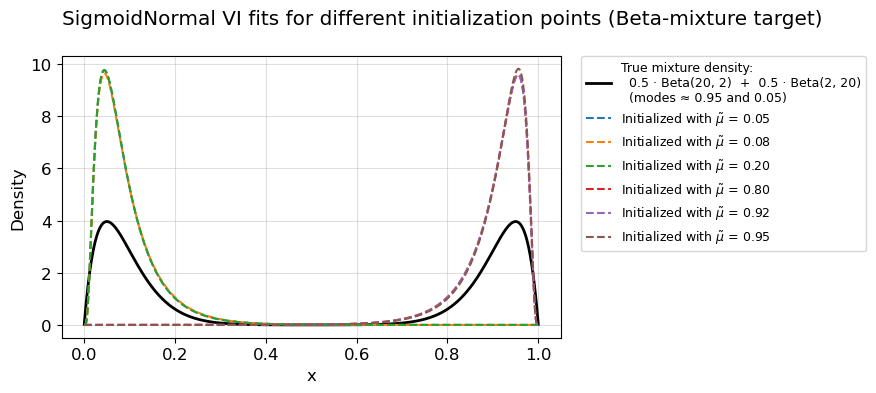

In [20]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9, 4))

xs = jnp.linspace(1e-4, 1 - 1e-4, 1000)

target_pdf = beta_mixture_pdf(xs, alpha_vec, beta_vec, mix_probs)

plt.plot(
    np.array(xs),
    np.array(target_pdf),
    label=(
        "True mixture density:\n"
        "  0.5 · Beta(20, 2)  +  0.5 · Beta(2, 20)\n"
        "  (modes ≈ 0.95 and 0.05)"
    ),
    linewidth=2,
    color='black'
)

# VI fits with improved labels
for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    mu0 = init_mus[i]
    label = r"Initialized with $\tilde{\mu}$ = " + f"{mu0:.2f}"
    plt.plot(
        np.array(xs),
        np.array(sigmoidnormal_pdf(xs, mu_uncon, sigma_uncon)),
        linestyle='--',
        linewidth=1.5,
        label=label
    )

plt.xlabel('x')
plt.ylabel('Density')
plt.grid(alpha=0.4)

# Legend fully outside on the right
plt.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

plt.suptitle('SigmoidNormal VI fits for different initialization points (Beta-mixture target)')
plt.tight_layout()
plt.show()

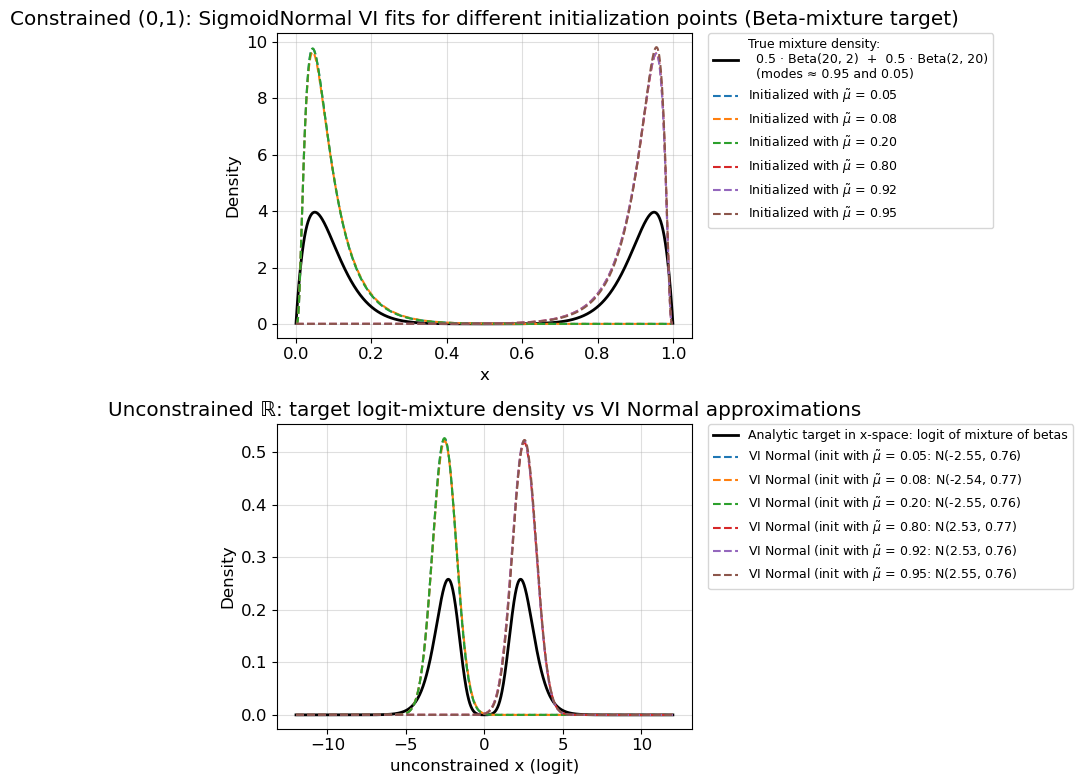

In [25]:
unconstrained_xs = jnp.linspace(-12.0, 12.0, 2000)  # covers logit of modes ~ logit(0.05)≈-2.94 and logit(0.95)≈+2.94

unconstrained_prior_pdf = beta_mixture_logit_pdf(unconstrained_xs, alpha_vec, beta_vec, mix_probs)

# ---- VI fits
vi_theta_pdfs = []
vi_x_pdfs = []
for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    vi_theta_pdfs.append(sigmoidnormal_pdf(theta_grid, mu_uncon, sigma_uncon))
    vi_x_pdfs.append(jnp.exp(dist.Normal(mu_uncon, sigma_uncon).log_prob(x_grid)))

# ------------------------------------------------------------------
# Final figure: 2 vertical subplots
#   Top: constrained (as you had it)
#   Bottom: unconstrained reals with analytic pushforward of mixture + VI normals
# ------------------------------------------------------------------
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=False)

# ---------------- Top: constrained support (keep as-is style) ----------------
ax = axes[0]

xs = jnp.linspace(1e-4, 1 - 1e-4, 1000)

target_pdf = beta_mixture_pdf(xs, alpha_vec, beta_vec, mix_probs)

ax.plot(
    np.array(xs),
    np.array(target_pdf),
    label=(
        "True mixture density:\n"
        "  0.5 · Beta(20, 2)  +  0.5 · Beta(2, 20)\n"
        "  (modes ≈ 0.95 and 0.05)"
    ),
    linewidth=2,
    color='black'
)

# VI fits with improved labels
for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    mu0 = init_mus[i]
    label = r"Initialized with $\tilde{\mu}$ = " + f"{mu0:.2f}"
    ax.plot(
        np.array(xs),
        np.array(sigmoidnormal_pdf(xs, mu_uncon, sigma_uncon)),
        linestyle='--',
        linewidth=1.5,
        label=label
    )

ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.grid(alpha=0.4)

# Legend fully outside on the right
ax.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

ax.set_title('Constrained (0,1): SigmoidNormal VI fits for different initialization points (Beta-mixture target)')


# ---------------- Bottom: unconstrained real line ----------------
ax2 = axes[1]

ax2.plot(np.array(unconstrained_xs), np.array(unconstrained_prior_pdf),
         linewidth=2, color='black',
         label="Analytic target in x-space: logit of mixture of betas")

for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    mu0 = init_mus[i]
    label = r"VI Normal (init with $\tilde{\mu}$ = " + f"{mu0:.2f}: N({mu_uncon:.2f}, {sigma_uncon:.2f})"
    ax2.plot(
        np.array(unconstrained_xs),
        np.array(normal_pdf(unconstrained_xs, mu_uncon, sigma_uncon)),
        linestyle='--',
        linewidth=1.5,
        label=label
    )


ax2.set_xlabel('unconstrained x (logit)')
ax2.set_ylabel('Density')
ax2.grid(alpha=0.4)
ax2.set_title('Unconstrained ℝ: target logit-mixture density vs VI Normal approximations')

ax2.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

plt.tight_layout()
plt.show()


In [ ]:


# Choose a Beta with heavy mass near 0 and 1
alpha_prior, beta_prior = 0.2, 0.2   # U-shaped

# rng = np.random.default_rng(123)
# n_samples = 100_000
# y_samples_raw = rng.beta(alpha_prior, beta_prior, size=n_samples)

# #clip away from 0 and 1 to avoid logit(0) = -inf, logit(1) = +inf
# eps = 1e-6
# y_samples = np.clip(y_samples_raw, eps, 1 - eps)

def beta_model(y=None):
    theta = numpyro.sample("theta", dist.Beta(alpha_prior, beta_prior))
    if y is not None: numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)

optimizer = Adam(step_size=1e-2)
elbo = TraceMeanField_ELBO(num_particles=100)
guide = AutoNormal(beta_model)
svi = SVI(beta_model, guide, optimizer, elbo)
svi_result = svi.run(
    jax.random.PRNGKey(0),
    100_000,
    y=jnp.array([]))
unconstrained_posterior = [
        float(np.asarray(svi_result.params["theta_auto_loc"])),
        float(np.asarray(svi_result.params["theta_auto_scale"]))
]

# Grids for plotting
y_grid = np.linspace(1e-4, 1 - 1e-4, 1000)  # avoid exact 0 and 1
x_grid = np.linspace(unconstrained_posterior[0] - 4 * unconstrained_posterior[1], unconstrained_posterior[0] + 4 * unconstrained_posterior[1], 1000)

# Beta pdf on (0,1), sigmoid-normal induced by fitted normal on x
beta_pdf = beta.pdf(y_grid, alpha_prior, beta_prior)
sigmoid_normal_pdf = sigmoidnormal_pdf(y_grid, unconstrained_posterior[0], unconstrained_posterior[1])

# fitted normal pdf on x, logit-Beta pdf on x
normal_pdf_x = normal_pdf(x_grid, unconstrained_posterior[0], unconstrained_posterior[1])
y_from_x = expit(x_grid)
logit_beta_pdf_x = beta.pdf(y_from_x, alpha_prior, beta_prior) * (y_from_x * (1 - y_from_x))


fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=False)

# ---------- (1) Constrained Plot: Beta vs SigmoidNormal ----------
ax = axes[0]
ax.plot(y_grid, beta_pdf, label=f"Beta({alpha_prior}, {beta_prior})", linewidth=2)
ax.plot(y_grid, sigmoid_normal_pdf, "--",
        label="Best Variational Approximation", linewidth=2)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Constrained support: Beta pdf vs best variational approximation")
ax.legend()
ax.set_ylim(0, 10)
ax.grid(True)

# ---------- (2) Unconstrained Plot: logit(Beta) vs Normal vs histogram of logit(Beta samples)----------
ax2 = axes[1]
ax2.plot(x_grid, normal_pdf_x, linewidth=2,
         label="Unconstrained Best Variational Approximation")
ax2.plot(x_grid, logit_beta_pdf_x, linewidth=2,
         label="True logit-Beta pdf") 
ax2.set_xlabel("x")
ax2.set_ylabel("density")
ax2.set_title("Unconstrained support: logit(Beta) vs Normal approximation")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()




 81%|████████  | 81105/100000 [00:13<00:02, 6821.64it/s, init loss: 3.5657, avg. loss [75001-80000]: 0.0459]